<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e5?scriptVersionId=178402246" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://whyy.org/wp-content/uploads/2021/09/AP_hurricane_ida_flooding_storm_090221_04-768x512.jpg)

# <span style="color: #44944A">I really sympathize with the people who had to go through the flood. I hope the governments of such countries will do everything possible to help people restore their property and life stability!

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv
/kaggle/input/flood-prediction-factors/flood.csv


## *Your Goal*: The goal of this competition is to predict the probability of a region flooding based on various factors.

<font face="Bahnschrift Condensed" style="font-size: 14pt; color: brown">
Flood detection refers to the process of identifying, monitoring, and alerting authorities or individuals about the presence or likelihood of flooding in a particular area. It involves the use of various technologies and methods to detect, predict, and mitigate the impacts of floods.
</font>

![](https://www.kaggle.com/competitions/73278/images/header)

# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 50px;">Table of Contents</span>

- [Import libraries](#1)
- [Open data files](#2)
- [Show first 5 lines of train data](#3)
- [Compare original train and competition train](#3.1)
- [Concatenate original train with competition train](#3.2)
- [Figure out how much duplicates in data](#3.3)
- [Shapes of train and test data](#4)
- [Display descriptive statistics of train data](#5)
- [Check the number of gaps for each feature](#6)
- [One-hot encoding](#7.3)
- [Display histograms of distribution](#8)
- [Let's count target of train data](#9)
- [Transform the data with log1p](#10)
- [Feature importance](#10.2)
- [Build a heat map of correlations](#11)
- [Define base models with tuned hyperparameters](#12)
- [Defining the meta-model with tuned hyperparameters](#13)
- [Creating and fitting the stacking model](#14)
- [Predict validation set and calculate metrics score](#15)
- [Predict the test data](#16)
- [Build DataFrame and make submission](#17)
- [Save the model into pickle file](#18)

<a id='1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

![](https://s.france24.com/media/display/f441dde2-f637-11ed-aeef-005056bf30b7/w:980/p:16x9/000_33FG2YF.jpg)

<a id='2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

<a id='3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## <span style="color: #A8E4A0">Let's look at quantity of scores for each feature

id
0          1
745303     1
745309     1
745308     1
745307     1
          ..
372658     1
372659     1
372660     1
372661     1
1117956    1
Name: count, Length: 1117957, dtype: int64



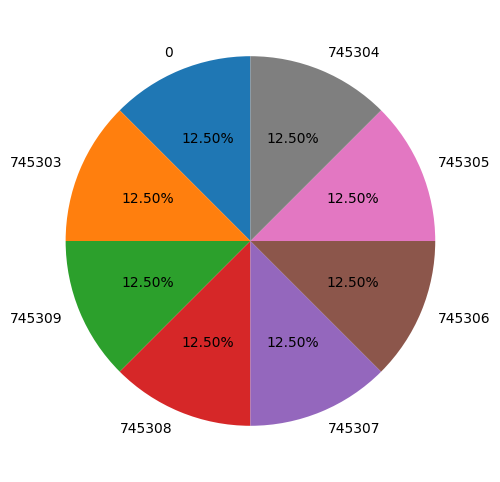

MonsoonIntensity
5     220936
4     214344
6     169080
3     160574
7     109210
2      86683
8      65954
9      33515
1      28946
10     14040
11      5851
0       5431
12      2062
13       729
14       391
15       169
16        42
Name: count, dtype: int64



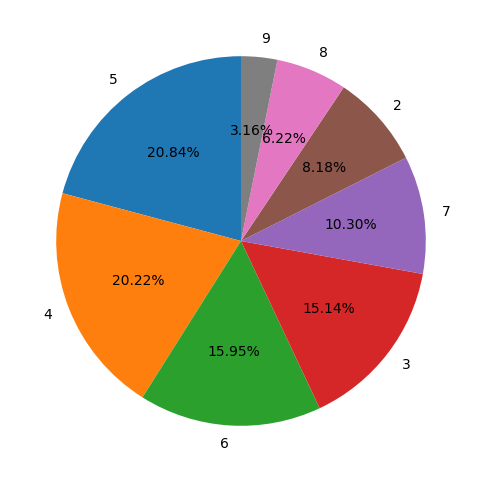

TopographyDrainage
5     221252
4     213368
3     161989
6     159003
7     102681
2      90058
8      72000
9      37544
1      29422
10     15524
11      6177
0       5541
12      2199
13       705
14       333
15       106
16        42
17        10
18         3
Name: count, dtype: int64



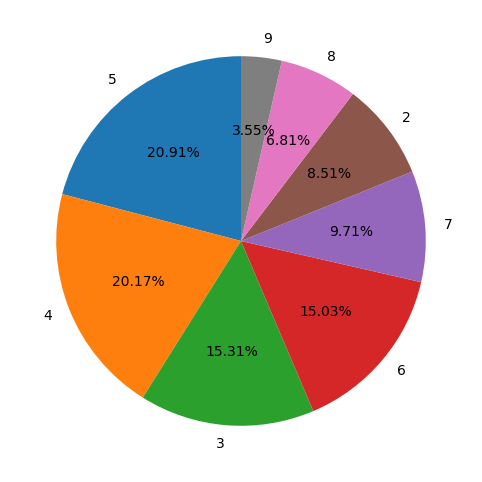

RiverManagement
5     218216
4     214079
6     167368
3     160049
7     108538
2      83782
8      71204
9      36232
1      28872
10     15170
11      5773
0       5407
12      2120
13       715
14       297
15        92
16        43
Name: count, dtype: int64



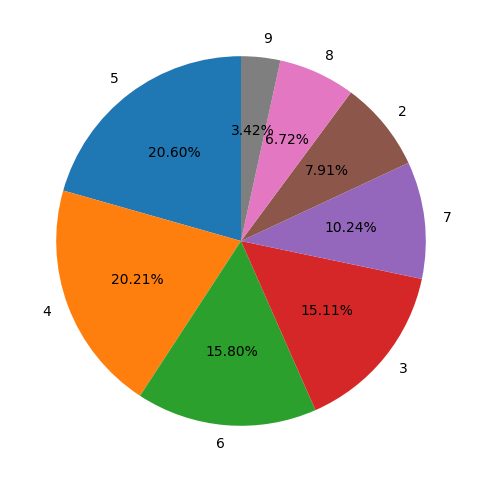

Deforestation
4     219733
5     217793
6     169175
3     157331
7     109039
2      85948
8      69237
9      34585
1      26881
10     13968
11      5706
0       5327
12      2079
13       706
14       293
15       115
16        35
17         6
Name: count, dtype: int64



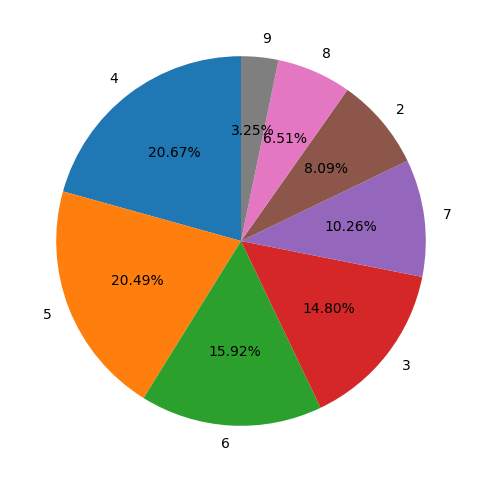

Urbanization
5     216722
4     212438
6     166703
3     162234
7     107693
2      86122
8      69295
9      36854
1      29672
10     15690
11      5689
0       5350
12      2211
13       791
14       313
15       137
16        36
17         7
Name: count, dtype: int64



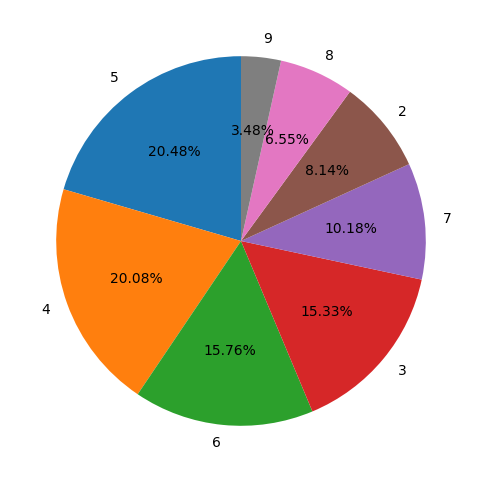

ClimateChange
5     218995
4     214268
6     169316
3     159728
7     107802
2      88158
8      69171
9      34687
1      27326
10     14457
11      5516
0       5347
12      2063
13       729
14       260
15        96
16        35
17         3
Name: count, dtype: int64



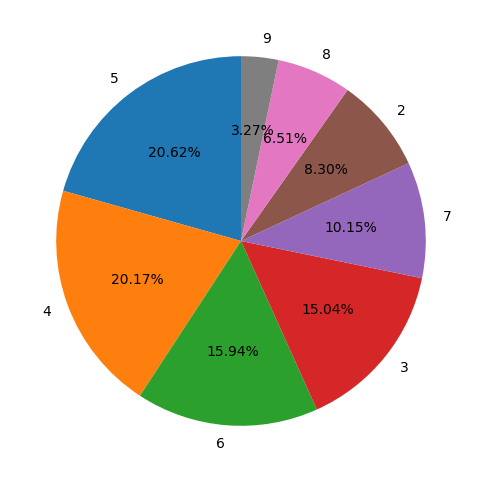

DamsQuality
5     218237
4     216308
6     164786
3     158316
7     108185
2      84763
8      71757
9      35903
1      28605
10     15121
11      6504
0       5878
12      2371
13       738
14       334
15       124
16        27
Name: count, dtype: int64



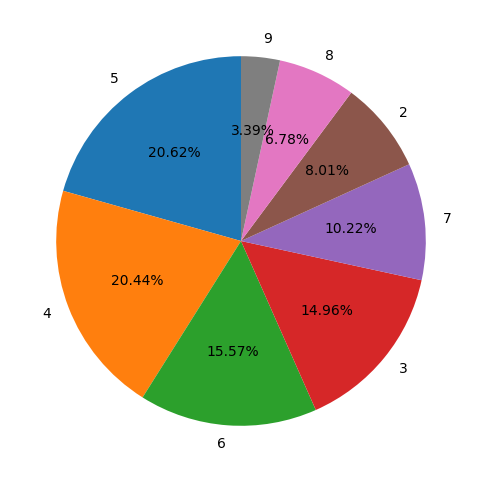

Siltation
5     222270
4     215232
6     164780
3     160419
7     106481
2      87322
8      68231
9      35460
1      28487
10     14815
11      5700
0       5381
12      2108
13       781
14       320
15       142
16        28
Name: count, dtype: int64



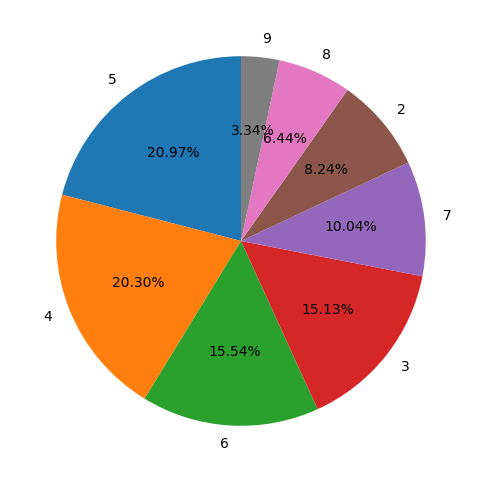

AgriculturalPractices
5     216644
4     214366
6     168426
3     160403
7     109213
2      85659
8      69347
9      36004
1      28587
10     14622
11      5900
0       5680
12      2085
13       631
14       254
15        96
16        40
Name: count, dtype: int64



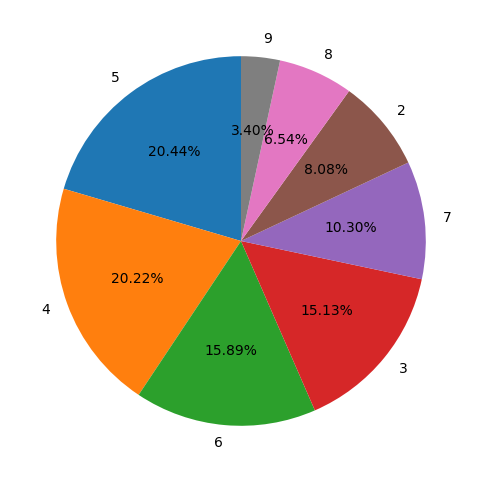

Encroachments
5     219971
4     219708
3     160683
6     158864
7     106434
2      84628
8      71237
9      37312
1      27979
10     15952
11      6262
0       5531
12      2145
13       750
14       343
15       110
16        33
17        13
18         2
Name: count, dtype: int64



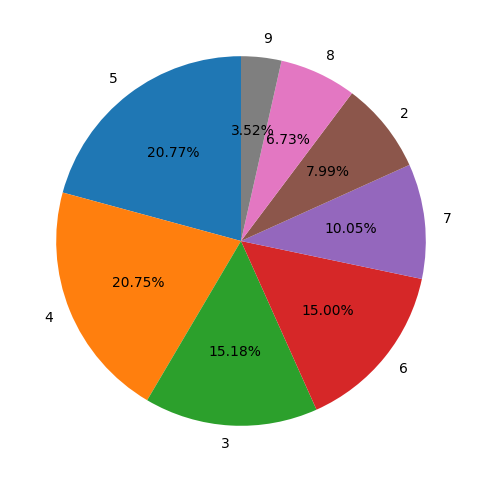

IneffectiveDisasterPreparedness
4     217365
5     215502
3     162862
6     162108
7     107059
2      85851
8      73046
9      36869
1      27756
10     15184
11      5725
0       5410
12      2055
13       673
14       336
15       124
16        32
Name: count, dtype: int64



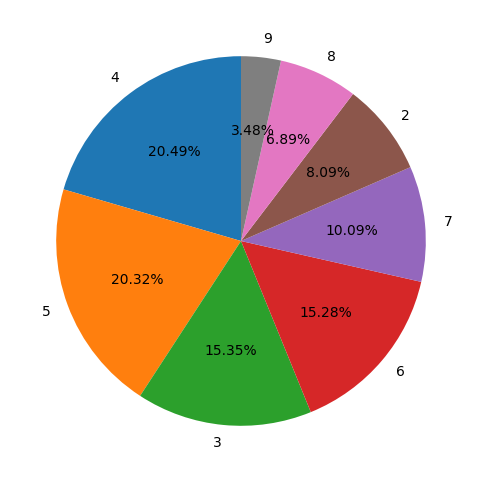

DrainageSystems
5     217753
4     216278
6     167358
3     159355
7     108156
2      84440
8      71360
9      34274
1      28923
10     14737
11      6240
0       5582
12      2203
13       786
14       325
15       133
16        44
17        10
Name: count, dtype: int64



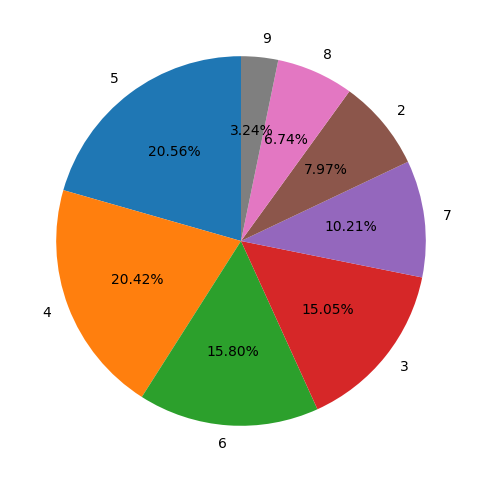

CoastalVulnerability
5     215378
4     213263
6     164640
3     162674
7     108310
2      84481
8      73577
9      35817
1      29108
10     14753
11      6602
0       5747
12      2370
13       761
14       332
15        99
16        38
17         7
Name: count, dtype: int64



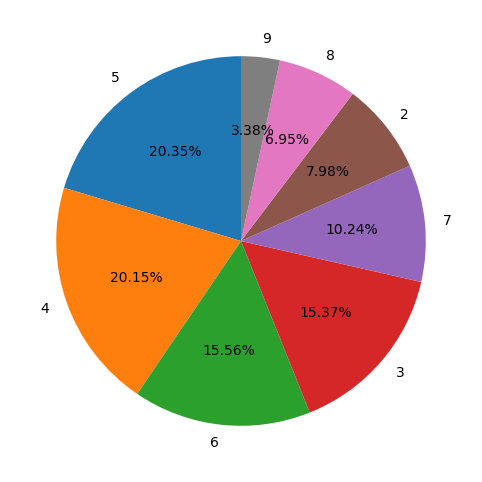

Landslides
5     213811
4     212833
6     164085
3     163932
7     109608
2      88129
8      72274
9      35411
1      29051
10     14442
11      5618
0       5516
12      2114
13       699
14       297
15       106
16        31
Name: count, dtype: int64



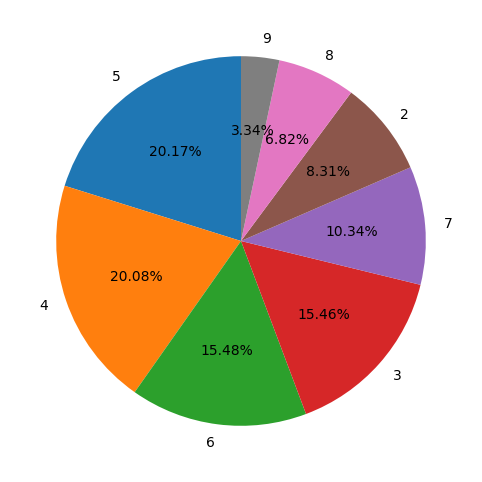

Watersheds
5     219756
4     213627
3     163564
6     159072
7     107309
2      88319
8      71822
9      36087
1      28867
10     14885
11      5734
0       5404
12      2227
13       811
14       329
15        94
16        50
Name: count, dtype: int64



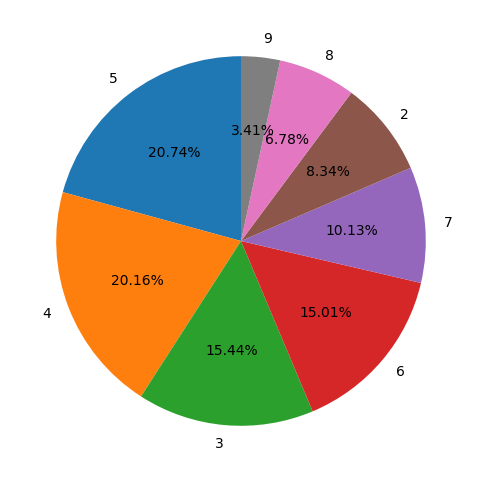

DeterioratingInfrastructure
4     218713
5     213578
6     168782
3     162850
7     107019
2      85513
8      67551
9      35832
1      29511
10     14684
11      5788
0       4953
12      2110
13       639
14       285
15       111
16        34
17         4
Name: count, dtype: int64



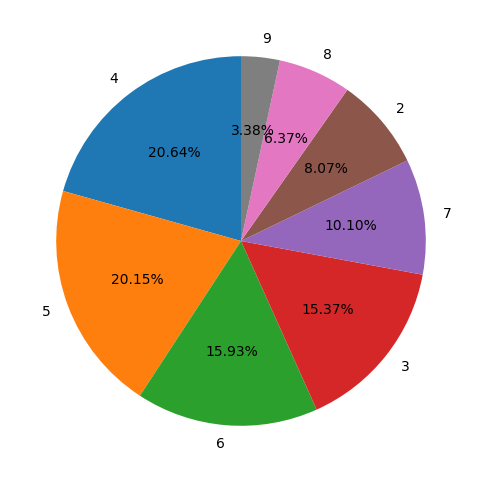

PopulationScore
4     221136
5     213102
6     163538
3     161487
7     106364
2      87742
8      72443
9      34422
1      28093
10     14804
11      5852
0       5536
12      2200
13       779
14       338
15        73
16        38
17         9
18         1
Name: count, dtype: int64



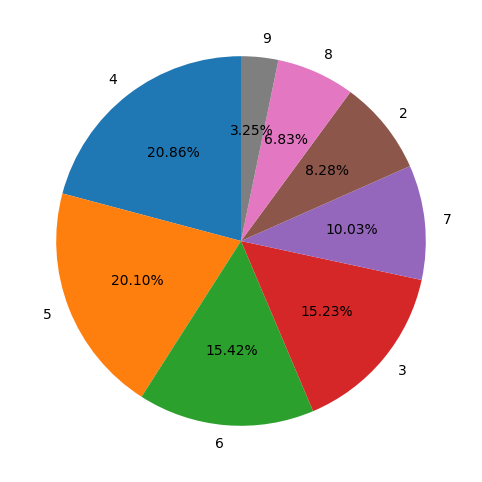

WetlandLoss
4     217045
5     214587
6     167265
3     161270
7     109524
2      84515
8      71347
9      34947
1      27958
10     15041
11      5993
0       5192
12      2141
13       689
14       299
15       102
16        37
17         3
18         1
19         1
Name: count, dtype: int64



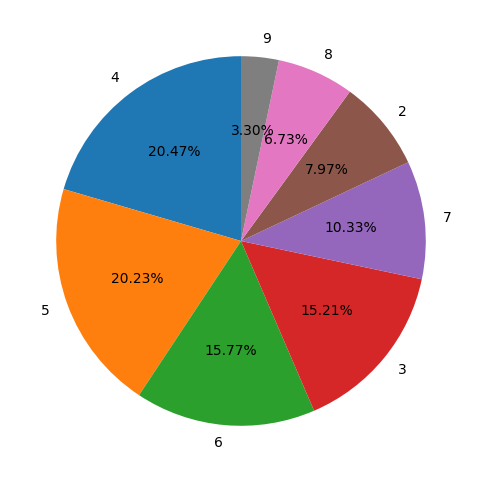

InadequatePlanning
5     217756
4     214851
3     165051
6     162099
7     106401
2      85421
8      71588
9      36289
1      27889
10     15694
11      5919
0       5619
12      2135
13       717
14       358
15       132
16        38
Name: count, dtype: int64



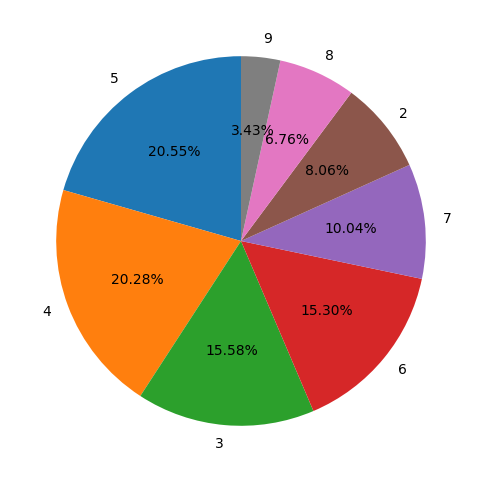

PoliticalFactors
4     215557
5     211264
3     164017
6     163682
7     108315
2      86873
8      72800
9      35675
1      28786
10     15286
11      6332
0       5995
12      2278
13       691
14       273
15        90
16        43
Name: count, dtype: int64



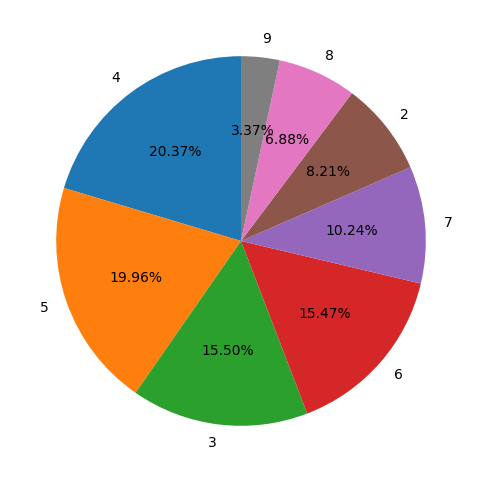

In [5]:
for feature in train.columns[:-1]:
    print(train[feature].value_counts(), end='\n\n')
    plt.figure(figsize=(9, 6))
    label_counts = train[feature].value_counts()
    plt.pie(label_counts[:8], labels=label_counts.index[:8], autopct='%1.2f%%', startangle=90)
    plt.show()

## <span style="color: #A8E4A0">Almost every where most frequently scores are 5, 4, 6, 3 and 7

In [6]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## <span style="color: #A8E4A0">Let's also add feature which will keep sum of all other scores

In [7]:
train['Total_score'] = sum([train[feature] for feature in train.columns[:-1]])
original_train['Total_score'] = sum([original_train[feature] for feature in original_train.columns[:-1]])
test['Total_score'] = sum([test[feature] for feature in test.columns])

train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability,Total_score
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445,94
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450,95
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530,101
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535,107
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415,76


In [8]:
train.Total_score.value_counts()[:15]

Total_score
23567      8
1035380    8
308259     7
1025319    7
843396     7
534222     7
402653     7
926678     7
768782     7
238785     7
400380     7
827513     7
637719     7
556979     7
1023726    7
Name: count, dtype: int64

In [9]:
train[train.columns[-2:]]

,FloodProbability,Total_score
0,0.445,94
1,0.450,95
2,0.530,101
3,0.535,107
4,0.415,76
...,...,...
1117952,0.495,1118051
1117953,0.480,1118049
1117954,0.485,1118052
1117955,0.495,1118054


## <span style="color: #A8E4A0">Target feature is **FloodProbability**

<a id='3.1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Compare original train and competition train</span>

In [10]:
print(original_train.shape)
original_train.columns.tolist()

(50000, 22)


['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability',
 'Total_score']

## <span style="color: #A8E4A0">In original data there is no **id** column

In [11]:
print(train.shape)
train.columns.tolist()

(1117957, 23)


['id',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability',
 'Total_score']

<a id='3.2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚣 Concatenate original train with competition train

In [12]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [13]:
train = pd.concat(objs=[train, original_train])
train.shape

(1167957, 22)

<a id='3.3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🛟 Figure out how much duplicates in data

In [14]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


<a id='4'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0">🚨 Shapes of train and test data</span>

In [15]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100:.2f}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100:.2f}% of all observations')

Train data: (1167957, 22)
Test data: (745305, 21)

Train data consists of 61.05% of all observations
Test data consists of 38.95% of all observations


![](https://akm-img-a-in.tosshub.com/lingo/itne/images/story/202208/new_project_18-sixteen_nine.jpg?size=948:533)

<a id='5'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚧 Display descriptive statistics of train data</span>

In [16]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1167957.0,4.924448,2.064482,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1167957.0,4.929129,2.100671,0.000,3.00,5.000,6.00,18.000
RiverManagement,1167957.0,4.957917,2.079283,0.000,4.00,5.000,6.00,16.000
Deforestation,1167957.0,4.945076,2.059346,0.000,4.00,5.000,6.00,17.000
Urbanization,1167957.0,4.944509,2.090501,0.000,3.00,5.000,6.00,17.000
ClimateChange,1167957.0,4.936415,2.065289,0.000,3.00,5.000,6.00,17.000
DamsQuality,1167957.0,4.958424,2.090286,0.000,4.00,5.000,6.00,16.000
Siltation,1167957.0,4.930394,2.073436,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1167957.0,4.945338,2.075964,0.000,3.00,5.000,6.00,16.000
Encroachments,1167957.0,4.951676,2.090378,0.000,4.00,5.000,6.00,18.000


<a id='6'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🏥 Check the number of gaps for each feature</span>

In [17]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
Total_score                        0
dtype: int64



TEST data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0

## <span style="color: #A8E4A0">There is no any gaps in the data

![](https://img.theweek.in/content/dam/week/week/news/world/images/2024/4/6/Russia-floods-reuters.jpg)

<a id='7'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌧️ Data types of training set</span>

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

<a id="7.3"></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 One-hot encoding

In [19]:
X = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

## <span style="color: #A8E4A0">Boostings and Random Forest can tackle with data without normalization

<a id='8'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Display histograms of distribution</span>

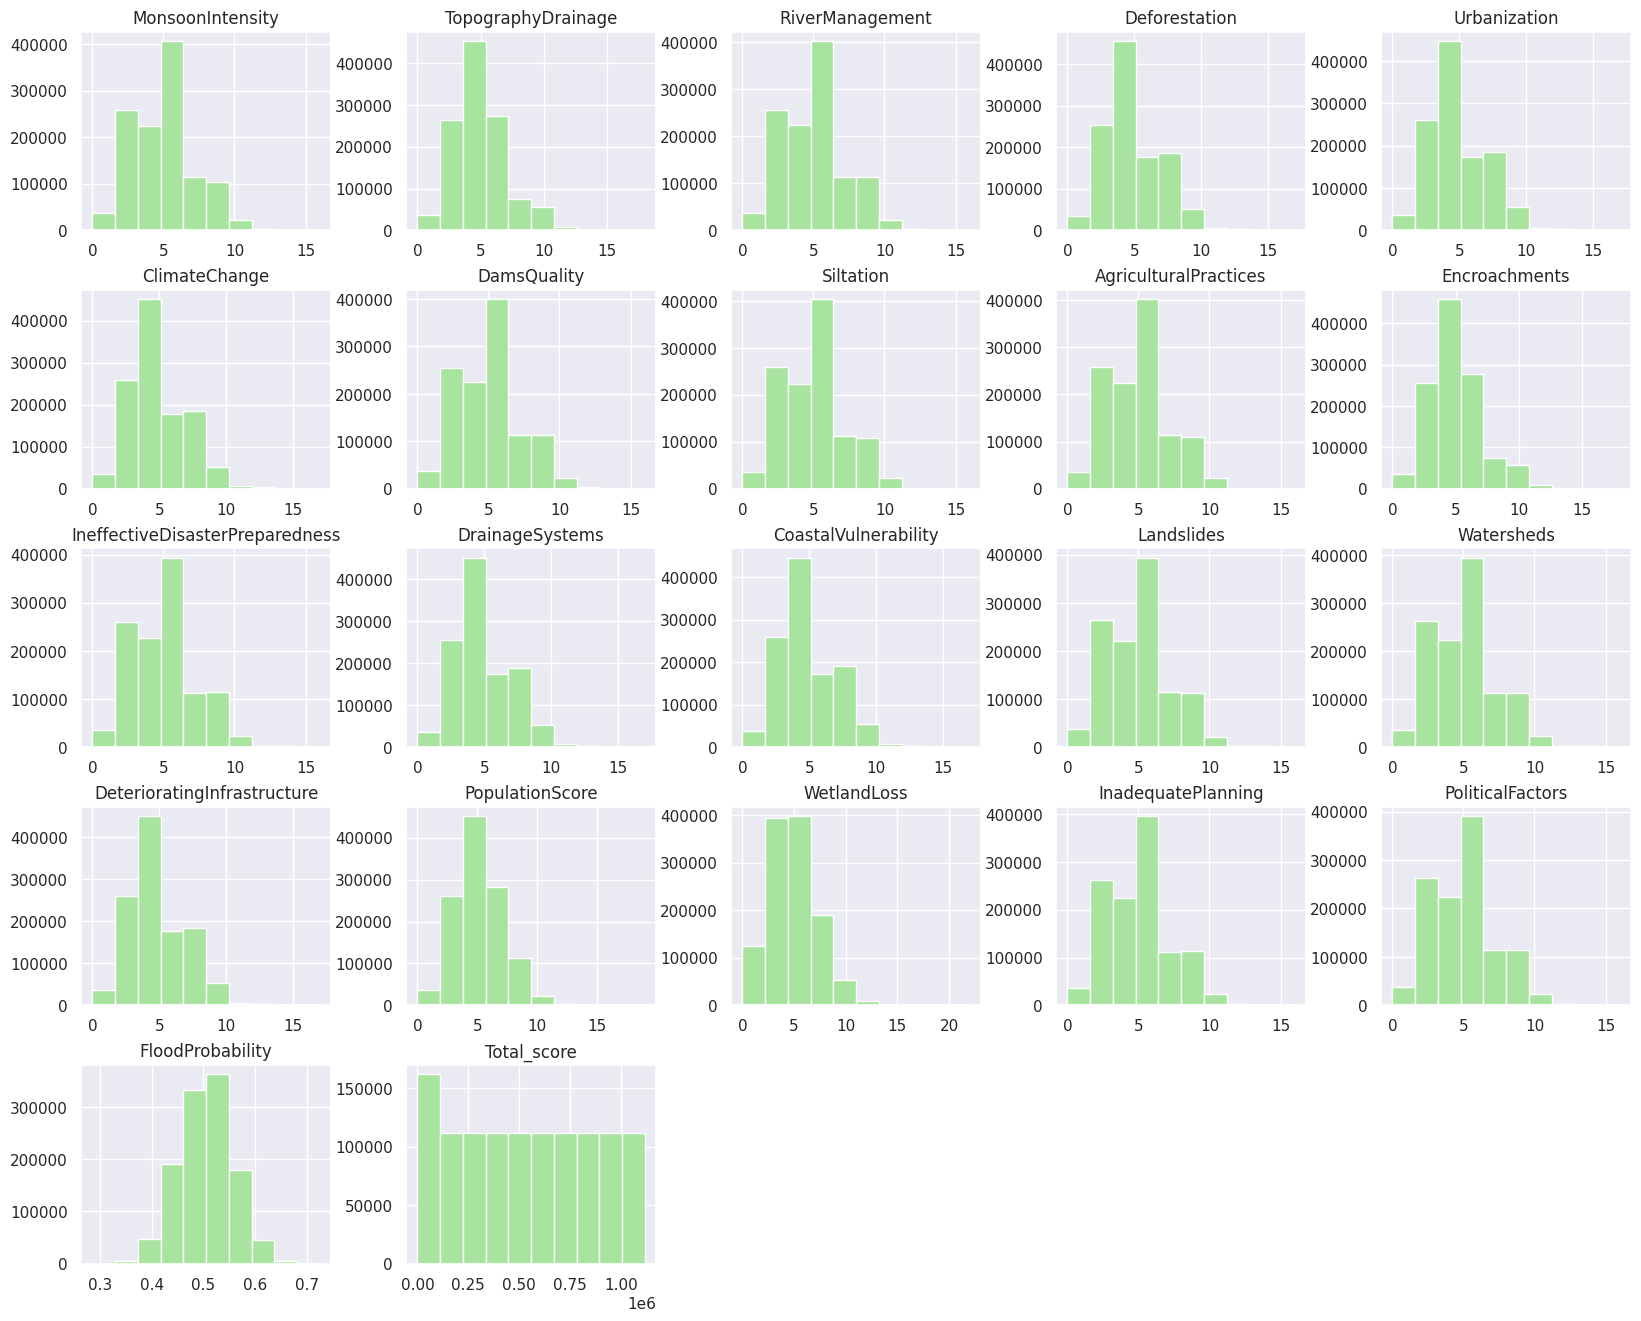

In [20]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='#A8E4A0');

<a id='10.2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Feature importance</span>

In [21]:
# Split the train data into X and y
X = X.drop(['FloodProbability'], axis=1)
y = train.FloodProbability

In [22]:
# %%time
# # I figured out best hyperparameters previously
# best_cat = CatBoostRegressor(
#     random_state=27
# )
    
# best_cat.fit(X, y)

In [23]:
# importance = best_cat.feature_importances_

# feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
#     .sort_values(ascending=True, by='importance')

# feature_importance.plot(kind='barh', figsize=(12, 8), color='#A8E4A0');

## <span style="color: #A8E4A0">All features have almost same importance

<a id='11'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Build a heat map of correlations</span>

In [24]:
X.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'Total_score'],
      dtype='object')

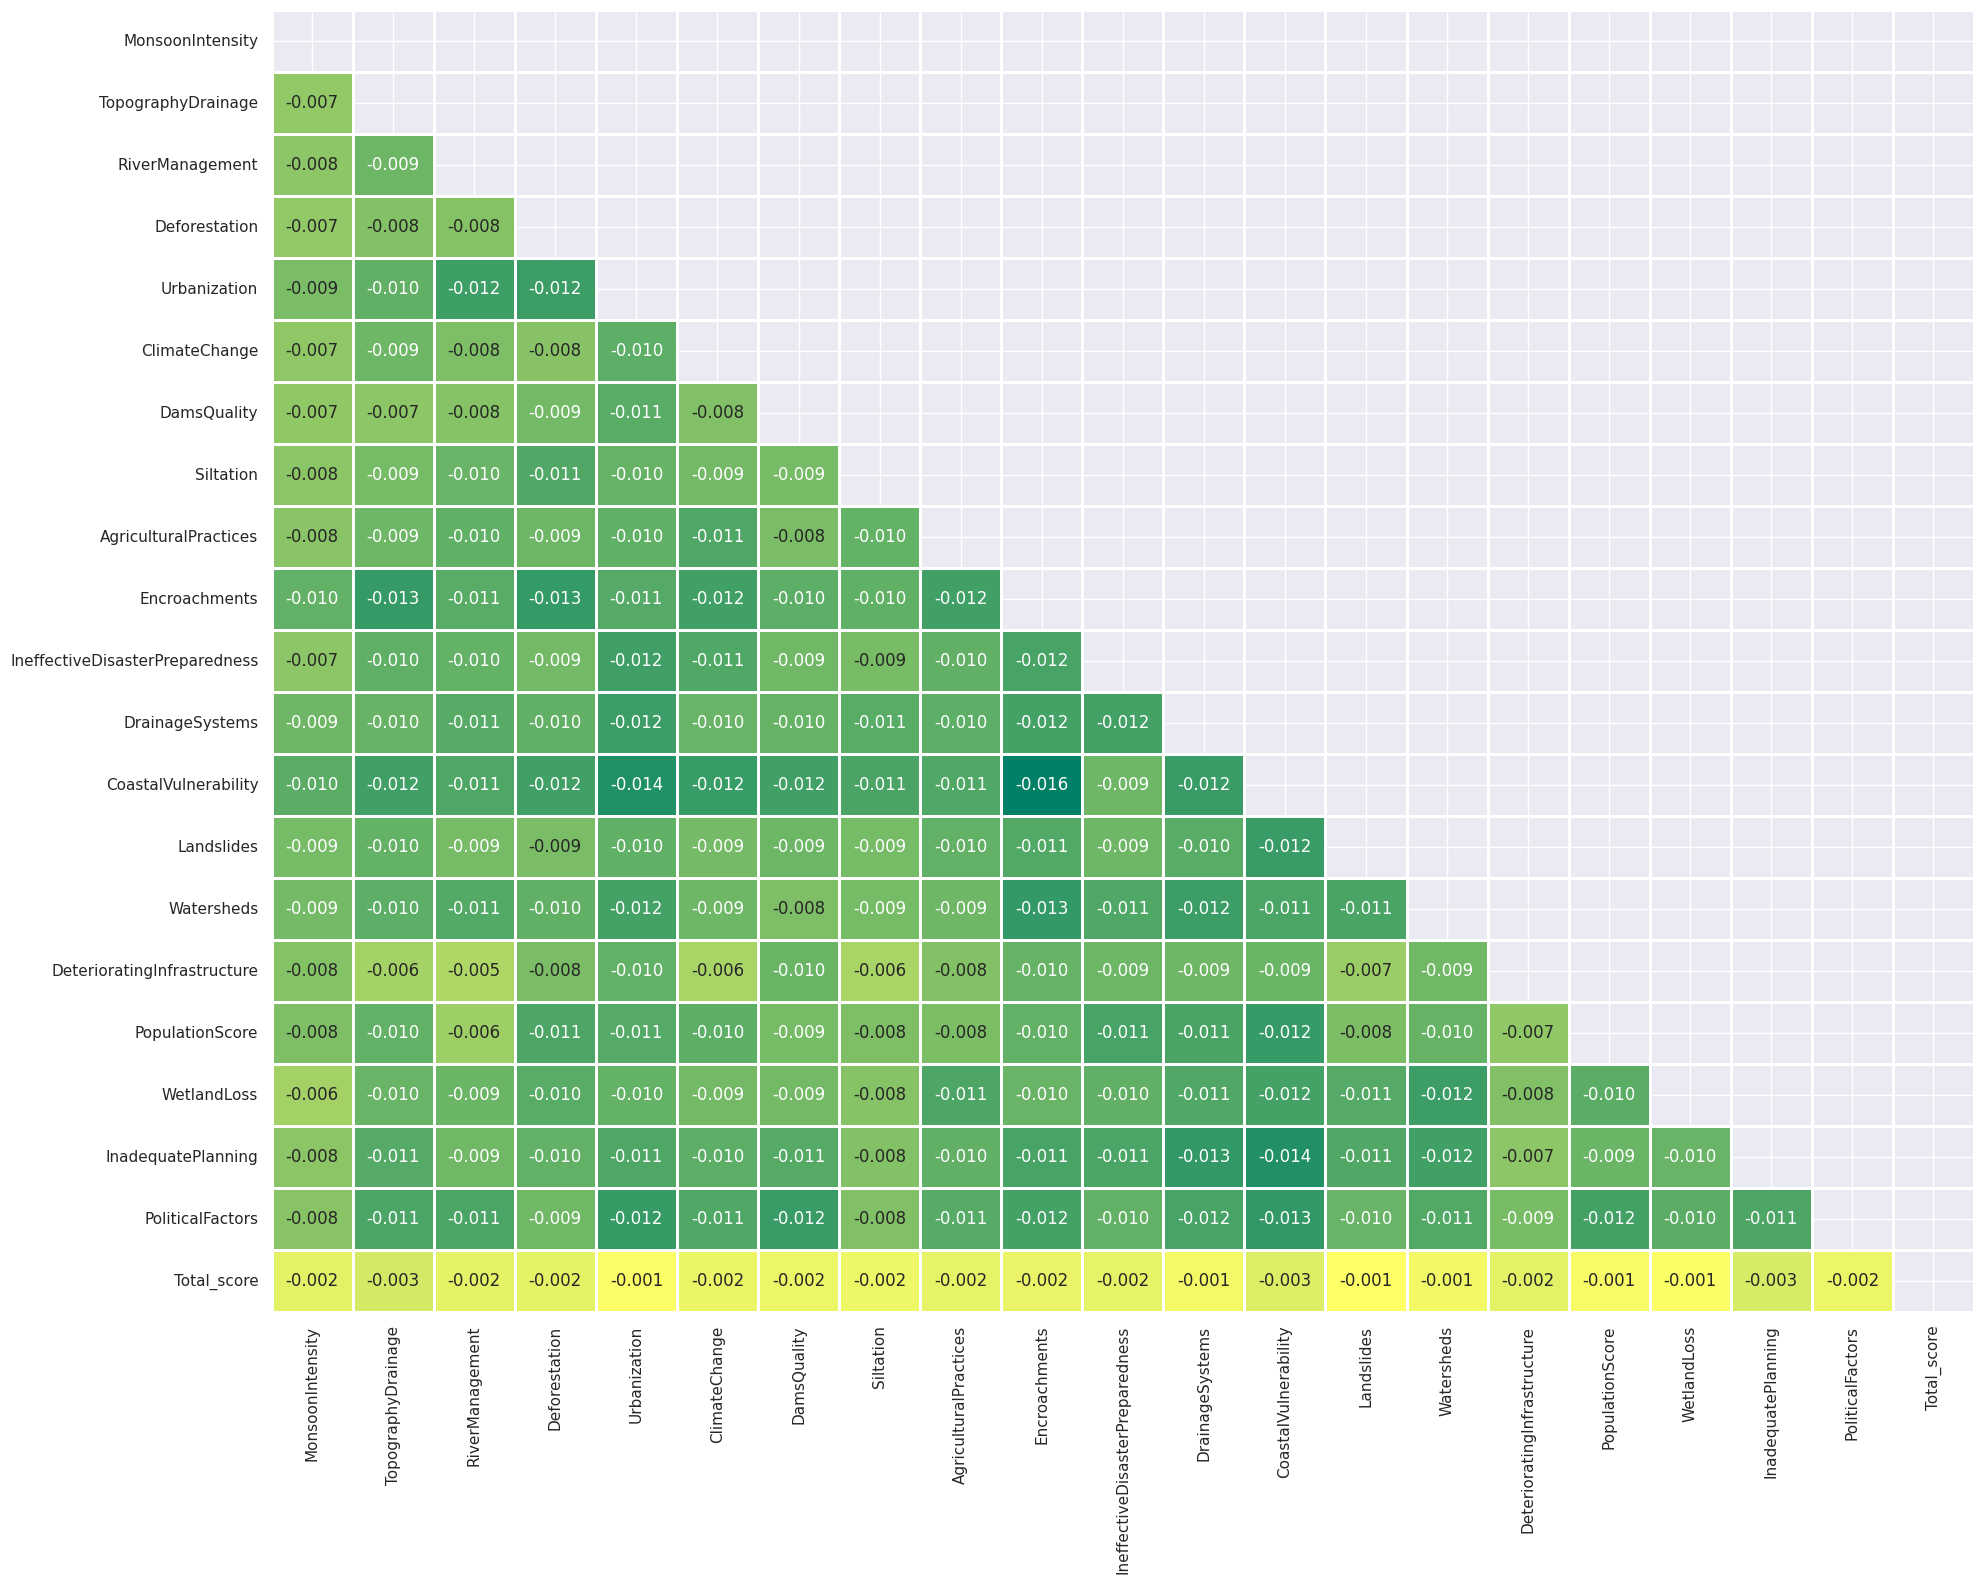

In [25]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.3f', mask=mask_train, cmap='summer', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

## <span style="color: #A8E4A0">There is no high correlated features

<a id='12'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚣 Define base models</span>

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">Ridge with Optuna</p>

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/2GzY9lVDj2Jdf8de7Kgc9Q.png)

In [26]:
# %%time
# def objective(trial):
#     model = Ridge(
#         alpha = trial.suggest_float('alpha', 0.0, 1.0),
#         solver = trial.suggest_categorical('solver', ['saga', 'sparse_cg', 'auto', 'sag', 'svd', 'cholesky', 'lsqr']),
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return r2_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="linear_regression", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  10
Best trial:
  Value:  0.8497187538861316
  Params: 
    alpha: 0.4257214105188958
    solver: svd

CPU times: user 45min 47s, sys: 5.51 s, total: 45min 52s
Wall time: 45min 45s
"""

'\nNumber of finished trials:  10\nBest trial:\n  Value:  0.8497187538861316\n  Params: \n    alpha: 0.4257214105188958\n    solver: svd\n\nCPU times: user 45min 47s, sys: 5.51 s, total: 45min 52s\nWall time: 45min 45s\n'

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">CatBoost with Optuna</p>

In [27]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 400, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 4, 14),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
    
#     kf = KFold(n_splits=5, shuffle=True, random_state=27)
#     r2_scores = []
    
#     for train_index, val_index in kf.split(X_train):
#         X_kf_train, X_kf_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         model.fit(X_kf_train, y_kf_train)
#         y_kf_pred = model.predict(X_kf_val)
#         r2 = r2_score(y_kf_val, y_kf_pred)
#         r2_scores.append(r2)
    
#     mean_r2_score = np.mean(r2_scores)
#     return mean_r2_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=5)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  10
Best trial:
  Value:  0.8519310944839222
  Params: 
    iterations: 824
    learning_rate: 0.07024611544300416
    colsample_bylevel: 0.32374524982071545
    min_data_in_leaf: 69
    depth: 9
    l2_leaf_reg: 5.938240087759686

CPU times: user 6h 21min 14s, sys: 9min 2s, total: 6h 30min 17s
Wall time: 2h 12s
"""

'\nNumber of finished trials:  10\nBest trial:\n  Value:  0.8519310944839222\n  Params: \n    iterations: 824\n    learning_rate: 0.07024611544300416\n    colsample_bylevel: 0.32374524982071545\n    min_data_in_leaf: 69\n    depth: 9\n    l2_leaf_reg: 5.938240087759686\n\nCPU times: user 6h 21min 14s, sys: 9min 2s, total: 6h 30min 17s\nWall time: 2h 12s\n'

In [28]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 400, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 4, 14),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(r2_score(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  2
Best trial:
  Value:  0.922180732174001
  Params: 
    iterations: 1335
    learning_rate: 0.0425762572228653
    colsample_bylevel: 0.7486274256896956
    min_data_in_leaf: 87
    depth: 8
    l2_leaf_reg: 62.311229612297524

CPU times: user 1h 16min 33s, sys: 46 s, total: 1h 17min 19s
Wall time: 22min 23s
"""

'\nNumber of finished trials:  2\nBest trial:\n  Value:  0.922180732174001\n  Params: \n    iterations: 1335\n    learning_rate: 0.0425762572228653\n    colsample_bylevel: 0.7486274256896956\n    min_data_in_leaf: 87\n    depth: 8\n    l2_leaf_reg: 62.311229612297524\n\nCPU times: user 1h 16min 33s, sys: 46 s, total: 1h 17min 19s\nWall time: 22min 23s\n'

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">XGBoost with Optuna</p>

In [29]:
%%time
def objective(trial):
    model = XGBRegressor(
        max_depth=trial.suggest_int('max_depth', 1, 100),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        n_estimators=trial.suggest_int('n_estimators', 1000, 2000),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        use_label_encoder=False,
        random_state=27
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        return r2_score(y_test, y_pred)
    except Exception as e:
        print(e)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=27)
study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

Number of finished trials:  20
Best trial:
  Value:  0.8526539882405902
  Params: 
    max_depth: 13
    learning_rate: 0.22472048294428892
    n_estimators: 1755
    min_child_weight: 10
    gamma: 8.58031910185836e-07
    subsample: 0.8936985751131682
    colsample_bytree: 0.04050040446078567
    reg_alpha: 0.16025160863896398
    reg_lambda: 6.875124639971543e-08

CPU times: user 1h 59min 39s, sys: 10.2 s, total: 1h 59min 49s
Wall time: 30min 36s


## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">LightGBM with Optuna</p>

In [30]:
# %%time
# def objective(trial):
#     model = LGBMRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         verbosity=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         num_leaves=trial.suggest_int('num_leaves', 2, 256),
#         min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return r2_score(y_test, y_pred)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

In [31]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

![](https://img.eurointegration.com.ua/images/doc/f/b/fbb045d-0-scotland.png)

In [32]:
# %%time
# lr = LinearRegression(n_jobs=-1)
# lr.fit(X_train, y_train)

# y_pred_val = lr.predict(X_val)

# r2_val = np.sqrt(r2_score(y_val, y_pred_val))
# print(f"R^2 score: {r2_val:.8f}")

"""
R^2 score: 0.92180191
CPU times: user 2.09 s, sys: 793 ms, total: 2.88 s
Wall time: 1.75 s
"""

'\nR^2 score: 0.92180191\nCPU times: user 2.09 s, sys: 793 ms, total: 2.88 s\nWall time: 1.75 s\n'

In [33]:
# %%time
# cat = CatBoostRegressor(
#     iterations=1441,
#     learning_rate=0.07024611544300416,
#     colsample_bylevel=0.32374524982071545,
#     min_data_in_leaf=69,
#     depth=10,
#     l2_leaf_reg=5.938240087759686,
#     random_state=27,
# )

# cat.fit(X_train, y_train)

In [34]:
# y_pred_val = cat.predict(X_val)

# r2_val = np.sqrt(r2_score(y_val, y_pred_val))
# print('Version 2, R^2 score: 0.92242615 (Default CatBoost)')
# print(f"R^2 score: {r2_val:.8f}")

"""
R^2 score: 0.92438560
"""

'\nR^2 score: 0.92438560\n'

In [35]:
# %%time
# xgb = XGBRegressor(
#     max_depth=13,
#     learning_rate=0.22472048294428892,
#     n_estimators=767,
#     min_child_weight=10,
#     gamma=8.58031910185836e-07,
#     subsample=0.8936985751131682,
#     colsample_bytree=0.04050040446078567,
#     reg_alpha=0.16025160863896398,
#     reg_lambda=6.875124639971543e-08,
#     random_state=27,
# )

# xgb.fit(X_train, y_train)
# y_pred_val = xgb.predict(X_val)
# r2_val = np.sqrt(r2_score(y_val, y_pred_val))
# print(f"XGB Regressor R^2 score: {r2_val:.8f}")

"""
XGB Regressor R^2 score: 0.92338181
CPU times: user 3min 29s, sys: 380 ms, total: 3min 29s
Wall time: 54 s
"""

'\nXGB Regressor R^2 score: 0.92338181\nCPU times: user 3min 29s, sys: 380 ms, total: 3min 29s\nWall time: 54 s\n'

In [36]:
# %%time
# lgbm = LGBMRegressor(
#     n_estimators=483,
#     max_depth=82,
#     learning_rate=0.02956613668999794,
#     boosting_type='gbdt',
#     num_leaves=251,
#     min_child_samples=90,
#     random_state=27,
# )

# lgbm.fit(X_train, y_train)
# y_pred_val = lgbm.predict(X_val)
# r2_val = np.sqrt(r2_score(y_val, y_pred_val))
# print(f"LGBM Regressor R^2 score: {r2_val:.8f}")

"""
LGBM Regressor R^2 score: 0.91749396
CPU times: user 4min 37s, sys: 9.1 s, total: 4min 46s
Wall time: 2min 58s
"""

'\nLGBM Regressor R^2 score: 0.91749396\nCPU times: user 4min 37s, sys: 9.1 s, total: 4min 46s\nWall time: 2min 58s\n'

In [37]:
base_models = [
#     ('XGBoost', XGBRegressor(
#         max_depth=13,
#         learning_rate=0.22472048294428892,
#         n_estimators=767,
#         min_child_weight=10,
#         gamma=8.58031910185836e-07,
#         subsample=0.8936985751131682,
#         colsample_bytree=0.04050040446078567,
#         reg_alpha=0.16025160863896398,
#         reg_lambda=6.875124639971543e-08,
#         random_state=27,
#     )),
    ('LightGBM', LGBMRegressor(
#         n_estimators=100,
#         max_depth=82,
#         learning_rate=0.02956613668999794,
#         boosting_type='gbdt',
#         num_leaves=251,
#         min_child_samples=90,
        random_state=27,
    )),
    ('CatBoost', CatBoostRegressor(
#         iterations=100,
#         learning_rate=0.07024611544300416,
#         colsample_bylevel=0.32374524982071545,
#         min_data_in_leaf=69,
#         depth=10,
#         l2_leaf_reg=5.938240087759686,
        random_state=27,
    )),
    ('Ridge_reg', Ridge(
        alpha=0.4263645403659503,
        solver='sag'
    ))
]

<a id='13'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛵ Defining the meta-model</span>

In [38]:
meta_model = XGBRegressor(
#     max_depth=13,
#     learning_rate=0.22472048294428892,
#     n_estimators=100,
#     min_child_weight=10,
#     gamma=8.58031910185836e-07,
#     subsample=0.8936985751131682,
#     colsample_bytree=0.04050040446078567,
#     reg_alpha=0.16025160863896398,
#     reg_lambda=6.875124639971543e-08,
    random_state=27,
)

<a id='14'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Creating and fitting the stacking model

In [39]:
# %%time
# # Validation model
# stacking_valid_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
# stacking_valid_model.fit(X_train, y_train)

# # Testing model
# stacking_test_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
# stacking_test_model.fit(X, y)

<a id='15'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Predict the validation set and calculate R^2 score</span>

In [40]:
# y_pred_val = stacking_valid_model.predict(X_val)

# r2_val = r2_score(y_val, y_pred_val)
# print(f"R^2 score: {r2_val:.8f}")

## <span style="color: #A8E4A0">Meta models:
- CatBoost: R^2 score = 0.86739402
- XGBoost: R^2 score: 0.86737344
- LGBM: R^2 score: 0.86744553

<a id='16'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 Predict on the test data</span>

In [41]:
# y_pred_test = stacking_test_model.predict(test)
# y_pred_test[:10]

![](https://rg.ru/uploads/images/2023/07/10/111sirius_d09.jpg)

<a id='17'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Build DataFrame and make submission</span>

In [42]:
# submission = pd.DataFrame({
#     'id': sample_submission.id,
#     'FloodProbability': y_pred_test
# })

# submission.to_csv('Kapturov_S4E5_submission.csv', index=False)
# submission.head(10)

<a id='18'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Save the model into pickle file</span>

In [43]:
# pickle.dump(cat, open("Kapturov_stacking_model.pkl", "wb"))

![](https://ichef.bbci.co.uk/ace/ws/640/cpsprodpb/14766/production/_109641838_057966017-1.jpg)